# Лабораторная работа №6

## Применение сверточных нейронных сетей (многоклассовая классификация)

Набор данных для распознавания языка жестов, который состоит из изображений размерности 28x28 в оттенках серого (значение пикселя от 0 до 255).

Каждое из изображений обозначает букву латинского алфавита, обозначенную с помощью жеста (изображения в наборе данных в оттенках серого).

Обучающая выборка включает в себя 27,455 изображений, а контрольная выборка содержит 7172 изображения.

Данные в виде _csv_-файлов можно скачать на сайте _Kaggle_: https://www.kaggle.com/datamunge/sign-language-mnist

### Задание 1

Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.

In [0]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
BASE_DIR = '/content/drive/My Drive/Colab Files/mo-2'

import sys

sys.path.append(BASE_DIR)

import os

In [0]:
DATA_ARCHIVE_NAME = 'sign-language-mnist.zip'

LOCAL_DIR_NAME = 'sign-language'

In [0]:
from zipfile import ZipFile

with ZipFile(os.path.join(BASE_DIR, DATA_ARCHIVE_NAME), 'r') as zip_:
    zip_.extractall(path = os.path.join(LOCAL_DIR_NAME, 'train'))

In [0]:
TRAIN_FILE_PATH = 'sign-language/train/sign_mnist_train.csv'
TEST_FILE_PATH = 'sign-language/train/sign_mnist_test.csv'

In [0]:
import pandas as pd

train_df = pd.read_csv(TRAIN_FILE_PATH)
test_df = pd.read_csv(TEST_FILE_PATH)

In [8]:
train_df.shape, test_df.shape

((27455, 785), (7172, 785))

In [0]:
IMAGE_DIM = 28

In [0]:
def row_to_label(_row):
    return _row[0]

def row_to_one_image(_row):
    return _row[1:].values.reshape((IMAGE_DIM, IMAGE_DIM, 1))

In [0]:
def to_images_and_labels(_dataframe):

    llll = _dataframe.apply(lambda row: row_to_label(row), axis = 1)
    mmmm = _dataframe.apply(lambda row: row_to_one_image(row), axis = 1)

    data_dict_ = { 'label': llll, 'image': mmmm }

    reshaped_ = pd.DataFrame(data_dict_, columns = ['label', 'image'])

    return reshaped_

In [0]:
train_df_reshaped = to_images_and_labels(train_df)
test_df_reshaped = to_images_and_labels(test_df)

### Задание 2

Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?

Возьмём _LeNet-5_.

In [0]:
! pip install tensorflow-gpu --pre --quiet

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.utils import to_categorical
import numpy as np

X_train = tf.keras.utils.normalize(np.asarray(list(train_df_reshaped['image'])),
                                   axis = 1)
X_test = tf.keras.utils.normalize(np.asarray(list(test_df_reshaped['image'])),
                                  axis = 1)

y_train = to_categorical(train_df_reshaped['label']
                         .astype('category').cat.codes.astype('int32'))
y_test = to_categorical(test_df_reshaped['label']
                        .astype('category').cat.codes.astype('int32'))

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27455, 28, 28, 1), (27455, 24), (7172, 28, 28, 1), (7172, 24))

In [0]:
CLASSES_N = y_train.shape[1]

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Conv2D, Dense, Flatten

model = tf.keras.Sequential()

model.add(Conv2D(6, kernel_size = (5, 5), strides = (1, 1),
                 activation = 'tanh', padding = 'same',
                 input_shape = (IMAGE_DIM, IMAGE_DIM, 1)))
model.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2),
                           padding = 'valid'))
model.add(Conv2D(16, kernel_size = (5, 5), strides = (1, 1),
                 activation = 'tanh', padding = 'valid'))
model.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2),
                           padding = 'valid'))
model.add(Flatten())
model.add(Dense(120, activation = 'tanh'))
model.add(Dense(84, activation = 'tanh'))
model.add(Dense(CLASSES_N, activation = 'softmax'))

In [0]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['categorical_accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [0]:
history = model.fit(x = X_train, y = y_train, epochs = 20,
                    validation_split = 0.15, verbose = 0)

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.figsize'] = 8, 6

sns.set()
sns.set_palette(sns.color_palette('hls'))

def plot_accuracy(_history,
                  _train_acc_name = 'accuracy',
                  _val_acc_name = 'val_accuracy'):

    plt.plot(_history.history[_train_acc_name])
    plt.plot(_history.history[_val_acc_name])

    plt.title('Model accuracy')

    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'], loc = 'right')

    plt.show()

def plot_loss(_history):

    plt.plot(_history.history['loss'])
    plt.plot(_history.history['val_loss'])

    plt.title('Model loss')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'], loc = 'right')

    plt.show()

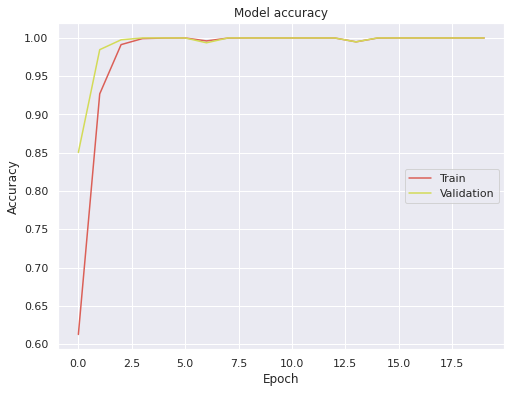

In [23]:
plot_accuracy(history, 'categorical_accuracy', 'val_categorical_accuracy')

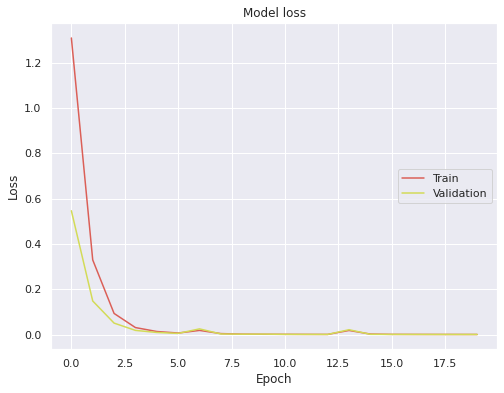

In [24]:
plot_loss(history)

In [25]:
results = model.evaluate(X_test, y_test)

print('Test loss, test accuracy:', results)

225/225 [==============================] - 1s 2ms/step - loss: 0.7977 - categorical_accuracy: 0.8358
Test loss, test accuracy: [0.7976991534233093, 0.835750162601471]


За 20 эпох удалось достичь точности 83% на тестовой выборке.

### Задание 3

Примените дополнение данных (_data augmentation_). Как это повлияло на качество классификатора?

In [0]:
def augment_image(image):

  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_crop_or_pad(image, IMAGE_DIM + 6, IMAGE_DIM + 6)
  image = tf.image.random_crop(image, size = [IMAGE_DIM, IMAGE_DIM, 1])

  return image.numpy()

In [27]:
X_train_augmented = np.zeros_like(X_train)

for i, img in enumerate(X_train):

    X_train_augmented[i] = augment_image(img)

X_train_augmented.shape

(27455, 28, 28, 1)

In [0]:
y_train_augmented = y_train

In [0]:
history_2 = model.fit(x = X_train_augmented, y = y_train_augmented, epochs = 20,
                      validation_split = 0.15, verbose = 0)

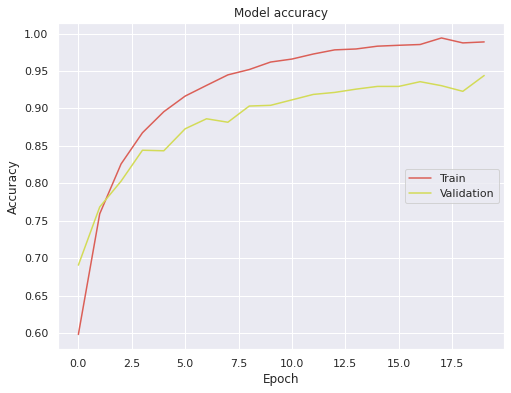

In [30]:
plot_accuracy(history_2, 'categorical_accuracy', 'val_categorical_accuracy')

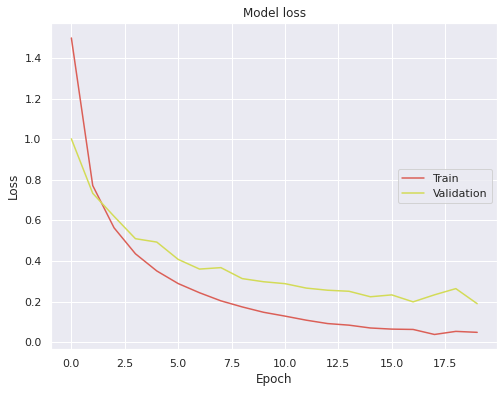

In [31]:
plot_loss(history_2)

In [32]:
results_2 = model.evaluate(X_test, y_test)

print('Test loss, test accuracy:', results_2)

225/225 [==============================] - 1s 2ms/step - loss: 0.3523 - categorical_accuracy: 0.9131
Test loss, test accuracy: [0.3523258864879608, 0.9131343960762024]


После того, как сеть обучилась на тех же данных, к которым был применён _data augmentation_, точность предсказания на тестовой выборке увеличилась до 91%.

### Задание 4

Поэкспериментируйте с готовыми нейронными сетями (например, _AlexNet_, _VGG16_, _Inception_ и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него?

Какой максимальный результат удалось получить на контрольной выборке?